In [281]:
import os, sys
import pandas as pd 
import numpy as np
from tqdm import tqdm
tqdm.pandas() # for progress_apply

process_dir = os.getcwd() # get the current directory before changing it
if os.getcwd().split("/")[-1] != "lobbying-market":
    sys.path.append("../..") # add main repo directory to path
    os.chdir("../..") # change to main repo directory

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

### Important things to note: 
* We need to lag assets and lobbying costs when calculating the `ratio`. When creating the dataset, may want to do something like a `LEFT JOIN` rather than `INNER JOIN`.
* There is some data that has ratio is greater than 1, which is kind of nonsense and highly affects our correlation coefficients
* For a given ratio, it is the Lobbying Expense(Qi) / Asset(Qi-1), since presumably the assets in the previous quarter are used towards the lobbying performed in the present quarter. 
* Here, market performance is the average percent return relative to the stock market if a stock is purchased at the start of a quarter and sold randomly in the present or future quarter

In [282]:
print(df.loc[0].merged_summary)

           end           val quarter  year  lobbying_costs  market_performance
0   2009-06-30   77888000000      Q2  2009       1890000.0            1.525541
1   2009-09-30   81612000000      Q3  2009       1490000.0            3.536464
2   2009-12-31   82096000000      Q4  2009       1690000.0          -15.707823
3   2010-03-31   84910000000      Q1  2010       1720000.0          -10.777842
4   2010-06-30   86113000000      Q2  2010       1850000.0           -8.558866
5   2010-09-30   91540000000      Q3  2010       1630000.0          -10.572159
6   2010-12-31   92306000000      Q4  2010       1710000.0           -1.676373
7   2011-03-31   99727000000      Q1  2011       1720000.0           12.083151
8   2011-06-30  108704000000      Q2  2011       1852000.0           18.859329
9   2011-09-30  107415000000      Q3  2011       1883000.0            3.530562
10  2011-12-31  112243000000      Q4  2011       1880000.0            5.326133
11  2012-03-31  118010000000      Q1  2012       179

Text(0.5, 1.0, 'Lagged By Quarter')

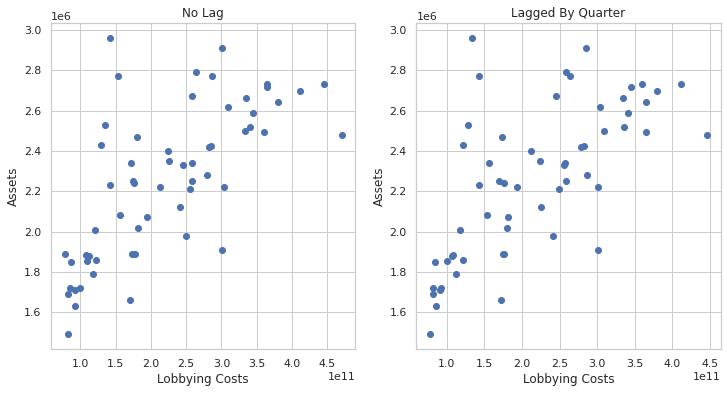

In [283]:
df = pd.read_pickle("data_processing/opensecrets_lobbying_scrape/lobbying_assets.pkl")
df1 = df.loc[0].merged_summary

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.scatter(df1['val'], df1['lobbying_costs'])
ax.set_xlabel('Lobbying Costs')
ax.set_ylabel('Assets')
ax.set_title('No Lag')

ax = fig.add_subplot(122)
ax.scatter(df1['val'][:-1], df1['lobbying_costs'][1:])
ax.set_xlabel('Lobbying Costs')
ax.set_ylabel('Assets')
ax.set_title('Lagged By Quarter')

Text(0, 0.5, 'Counts')

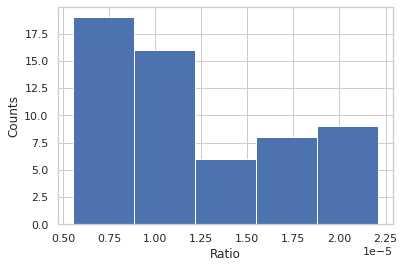

In [284]:
ratio = df1['lobbying_costs'].values[1:] / df1['val'].values[:-1] 
plt.hist(ratio, bins=5)
plt.xlabel('Ratio')
plt.ylabel('Counts')

In [285]:
import pandas as pd
from datetime import date
import yfinance as yf
import requests_cache
# Enable caching with requests_cache for an hour
requests_cache.install_cache('yfinance_cache', expire_after=3600)  

# Tickers of companies we want to study
tickers = df.loc[0].ticker
# Start date and end date of the data we want to download
START = date(df1.year.values.min(), 1, 1)
END = date(df1.year.values.max(), 12, 31)
# Downloading the data
data = yf.download(tickers, start=START, end=END)

[*********************100%%**********************]  1 of 1 completed



In [286]:
# Tickers of companies we want to study
tickers = '^GSPC'
# Start date and end date of the data we want to download
START = date(2008, 1, 1)
END = date(2023, 12, 31)
# Downloading the data
sp500_data = yf.download(tickers, start=START, end=END)

[*********************100%%**********************]  1 of 1 completed



### Suppose you know lobbying costs before they are filed. 

In [287]:
def get_start_end(year, quarter):
    if quarter == 'Q1':
        return date(year, 1, 1), date(year, 3, 31)
    elif quarter == 'Q2':
        return date(year, 4, 1), date(year, 6, 30)
    elif quarter == 'Q3':
        return date(year, 7, 1), date(year, 9, 30)
    elif quarter == 'Q4':
        return date(year, 10, 1), date(year, 12, 31)

In [288]:
# return the quarter that is d quarters away from a given quarter
def get_next_quarter(year, quarter, d):
    if quarter == 'Q1':
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year, 'Q2', d-1)
    elif quarter == 'Q2':
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year, 'Q3', d-1)
    elif quarter == 'Q3':
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year, 'Q4', d-1)
    elif quarter == 'Q4':
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year+1, 'Q1', d-1)

In [289]:
data.index

DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=3774, freq=None)

In [290]:
print(data.index.values)

['2009-01-02T00:00:00.000000000' '2009-01-05T00:00:00.000000000'
 '2009-01-06T00:00:00.000000000' ... '2023-12-27T00:00:00.000000000'
 '2023-12-28T00:00:00.000000000' '2023-12-29T00:00:00.000000000']


In [291]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,19.530001,20.400000,19.370001,20.330000,15.038727,50084000
2009-01-05,20.200001,20.670000,20.059999,20.520000,15.179272,61475200
2009-01-06,20.750000,21.000000,20.610001,20.760000,15.356808,58083400
2009-01-07,20.190001,20.290001,19.480000,19.510000,14.432145,72709900
2009-01-08,19.629999,20.190001,19.549999,20.120001,14.883381,70255400
...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100
2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400


In [292]:
date_ex = pd.Timestamp(date(2009,1,2))
print(date_ex)
data.loc[date_ex]

2009-01-02 00:00:00


Open         1.953000e+01
High         2.040000e+01
Low          1.937000e+01
Close        2.033000e+01
Adj Close    1.503873e+01
Volume       5.008400e+07
Name: 2009-01-02 00:00:00, dtype: float64

In [293]:
# use data to obtain the difference in stock price from the first day of a quarter to the first day of a future quarter
def get_stock_price_change(data, year, quarter, d):
    year, quarter = get_next_quarter(year, quarter, 1)
    start, end = get_start_end(year, quarter)
    start = pd.Timestamp(start) ; end = pd.Timestamp(end)
    initial_price = data['Adj Close'].loc[start]
    year, quarter = get_next_quarter(year, quarter, d)
    start, end = get_start_end(year, quarter)
    start = pd.Timestamp(start) ; end = pd.Timestamp(end)
    final_price = data['Adj Close'].loc[start]
    percent_change = 100 * (final_price - initial_price) / initial_price
    return percent_change


In [294]:
# given start and end date, return data indices that are within the range (including start and end)
def get_data_range(data, start, end):
    return data.index[(data.index >= start) & (data.index <= end)]

# get closest date in the future to a given date
def get_next_date(data, date):
    return data.index[data.index >= date][0]

# get closest date in the past to a given date
def get_prev_date(data, date):
    return data.index[data.index <= date][-1]

In [295]:
# use data to obtain the difference in stock price from the first day of a quarter to the first day of a future quarter
def get_avg_stock_price_change(data, year, quarter, d):
    # get the first day of the next quarter
    year, quarter = get_next_quarter(year, quarter, 1)
    start, end = get_start_end(year, quarter)
    start = pd.Timestamp(start) ; end = pd.Timestamp(end)
    if start >= data.index[-1] or end <= data.index[0]:
        return np.nan
    start = get_next_date(data, start) ; end = get_prev_date(data, end)
    initial_price = data['Adj Close'].loc[start]

    # get the first day of the future quarter (d = 0 means you will sell randomly in next quarter)
    year, quarter = get_next_quarter(year, quarter, d)
    start, end = get_start_end(year, quarter)
    dates = get_data_range(data, pd.Timestamp(start), pd.Timestamp(end))
    final_price = data['Adj Close'].loc[dates]
    percent_change = 100 * (final_price - initial_price) / initial_price
    return percent_change.mean()


In [296]:
def get_market_performance(data, sp500_data, year, quarter, d):
    stock_change = get_avg_stock_price_change(data, year, quarter, d)
    sp500_change = get_avg_stock_price_change(sp500_data, year, quarter, d)
    return stock_change - sp500_change

df1['market_performance'] = df1.progress_apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, 2), axis=1)

100%|██████████| 59/59 [00:00<00:00, 430.02it/s]


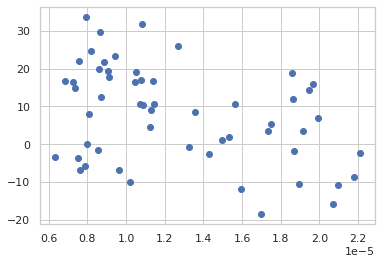

In [297]:
plt.scatter(ratio, df1['market_performance'].loc[1:])

In [298]:
get_market_data(df.loc[73].ticker, df.loc[73].merged_summary)

ValueError: zero-size array to reduction operation minimum which has no identity

In [299]:
# remove index 73
df = df.drop(73)
df.reset_index(drop=True, inplace=True)

In [300]:
# let's do this for all the companies in our list now
def get_market_data(ticker, df1):
    # Tickers of companies we want to study
    START = date(df1.year.values.min(), 1, 1)
    END = date(df1.year.values.max(), 12, 31)
    # Downloading the data
    data = yf.download(ticker, start=START, end=END)
    return data

df['stock_data'] = df.progress_apply(lambda x: get_market_data(x['ticker'], x['merged_summary']), axis = 1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [301]:
def compute_ratio(df1):
    return df1['lobbying_costs'].values[1:] / df1['val'].values[:-1]

df['ratio'] = df.apply(lambda x: compute_ratio(x['merged_summary']), axis = 1)
# market_performance = df.progress_apply( lambda x : x.merged_summary.apply(lambda y: get_market_performance(x.stock_data, sp500_data, y.year, y.quarter, 2), axis=1), axis=1)

100%|██████████| 110/110 [00:00<00:00, 4947.28it/s]


In [309]:
market_performance_list = []
for i in tqdm(range(len(df))):
    df1 = df.loc[i].merged_summary
    data = df.loc[i].stock_data
    df1['market_performance'] = df1.progress_apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, 2), axis=1)
    market_performance_list.append(df1['market_performance'].values)

100%|██████████| 110/110 [00:09<00:00, 11.32it/s]


In [318]:
df.loc[0]['ratio'].shape

(58,)

In [310]:
market_performance_list[0].shape

(59,)

In [325]:
print(np.max([df.loc[i].ratio.max() for i in range(len(df))]))

ValueError: zero-size array to reduction operation maximum which has no identity

(0.0, 0.001)

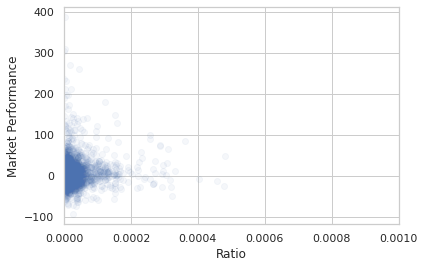

In [332]:
for i in range(len(df)):
    plt.scatter(df.loc[i].ratio, market_performance_list[i][1:], c = 'b', alpha = 0.05)
plt.xlabel('Ratio')
plt.ylabel('Market Performance')
plt.xlim([0,1e-3])

In [333]:
ratio_all = np.concatenate([df.loc[i].ratio for i in range(len(df))])
market_performance_all = np.concatenate([market_performance_list[i][1:] for i in range(len(df))])

In [337]:
# remove nans
arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
ratio_all = ratio_all[~arg_nan]
market_performance_all = market_performance_all[~arg_nan]

In [338]:
np.corrcoef(ratio_all, market_performance_all)

array([[1.00000000e+00, 9.81062429e-04],
       [9.81062429e-04, 1.00000000e+00]])

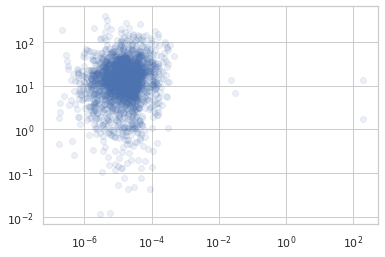

In [341]:
plt.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1)

  0%|          | 0/8 [00:00<?, ?it/s]

[[1.         0.01762362]
 [0.01762362 1.        ]]


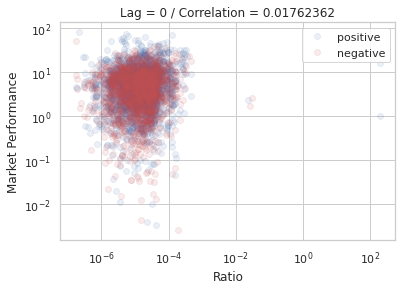

 12%|█▎        | 1/8 [00:08<00:57,  8.15s/it]

[[1.         0.00457991]
 [0.00457991 1.        ]]


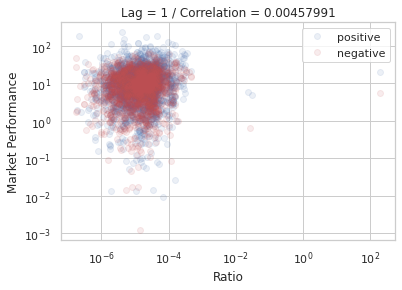

 25%|██▌       | 2/8 [00:15<00:46,  7.81s/it]

[[1.00000000e+00 9.81062429e-04]
 [9.81062429e-04 1.00000000e+00]]


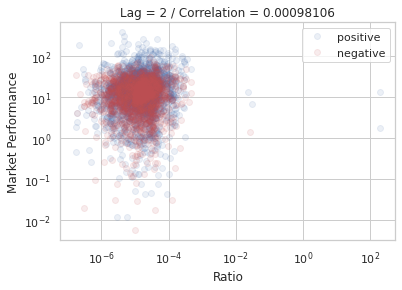

 38%|███▊      | 3/8 [00:23<00:38,  7.71s/it]

[[1.         0.01089376]
 [0.01089376 1.        ]]


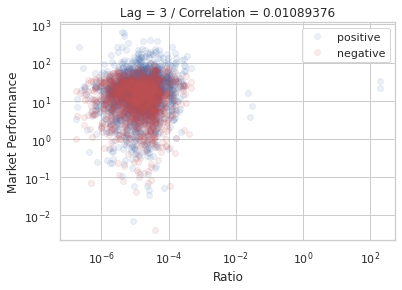

 50%|█████     | 4/8 [00:31<00:31,  7.94s/it]

[[1.         0.01200889]
 [0.01200889 1.        ]]


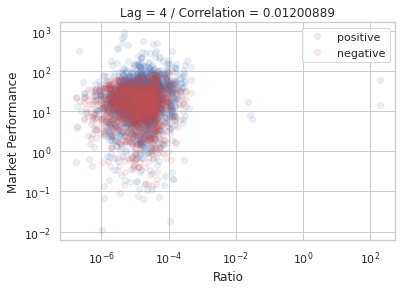

 62%|██████▎   | 5/8 [00:39<00:23,  7.90s/it]

[[1.         0.00514827]
 [0.00514827 1.        ]]


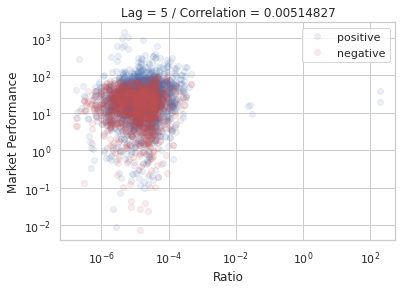

 75%|███████▌  | 6/8 [00:47<00:15,  7.90s/it]

[[1.         0.00624544]
 [0.00624544 1.        ]]


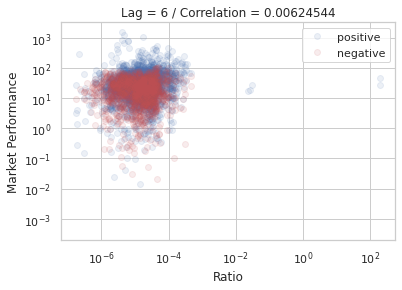

 88%|████████▊ | 7/8 [00:55<00:07,  7.94s/it]

[[1.        0.0085427]
 [0.0085427 1.       ]]


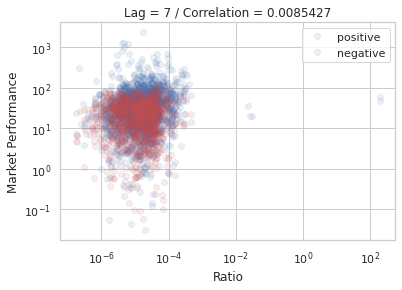

100%|██████████| 8/8 [01:02<00:00,  7.86s/it]


In [350]:
for d in tqdm(range(0, 8)):
    market_performance_list = []
    for i in range(len(df)):
        df1 = df.loc[i].merged_summary
        data = df.loc[i].stock_data
        df1['market_performance'] = df1.apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, d), axis=1)
        market_performance_list.append(df1['market_performance'].values)

    ratio_all = np.concatenate([df.loc[i].ratio for i in range(len(df))])
    market_performance_all = np.concatenate([market_performance_list[i][1:] for i in range(len(df))])

    # remove nans
    arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
    ratio_all = ratio_all[~arg_nan]
    market_performance_all = market_performance_all[~arg_nan]

    print(np.corrcoef(ratio_all, market_performance_all))

    plt.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1, c= 'b', label = 'positive')
    plt.loglog(ratio_all, -market_performance_all, 'o', alpha = 0.1, c = 'r', label = 'negative')
    plt.xlabel('Ratio')
    plt.ylabel('Market Performance')
    plt.title('Lag = ' + str(d) + ' / ' + 'Correlation = ' + str(np.round(np.corrcoef(ratio_all, market_performance_all)[0,1], 8)))
    plt.legend()
    plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1.         -0.00351006]
 [-0.00351006  1.        ]]


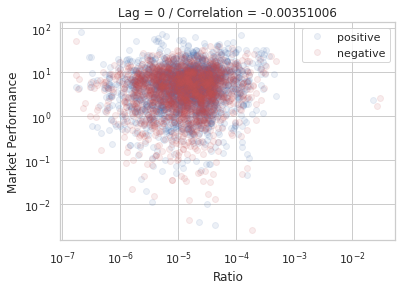

 12%|█▎        | 1/8 [00:07<00:54,  7.76s/it]

[[1.         0.00266182]
 [0.00266182 1.        ]]


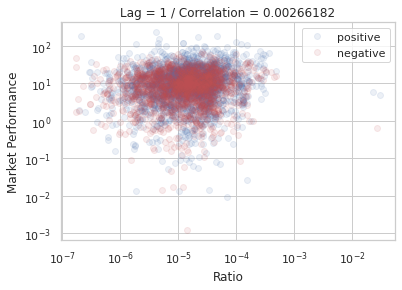

 25%|██▌       | 2/8 [00:15<00:46,  7.76s/it]

[[1.         0.00242203]
 [0.00242203 1.        ]]


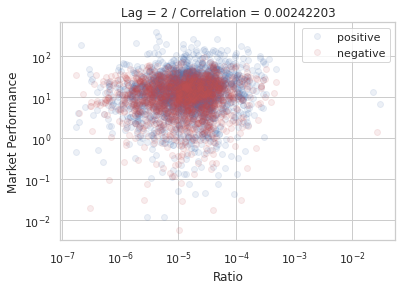

 38%|███▊      | 3/8 [00:23<00:38,  7.78s/it]

[[1.         0.00215991]
 [0.00215991 1.        ]]


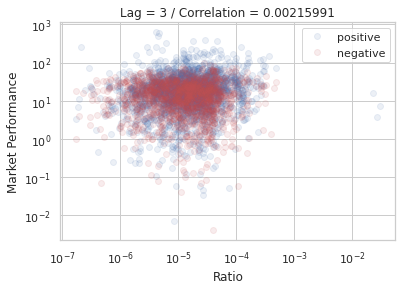

 50%|█████     | 4/8 [00:32<00:32,  8.20s/it]

[[1.         0.00170426]
 [0.00170426 1.        ]]


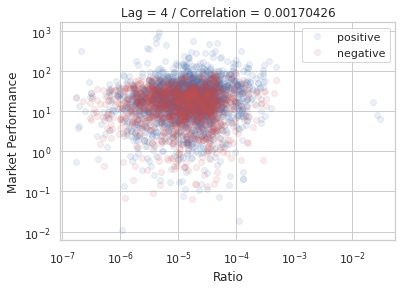

 62%|██████▎   | 5/8 [00:40<00:24,  8.20s/it]

[[1.         0.00202479]
 [0.00202479 1.        ]]


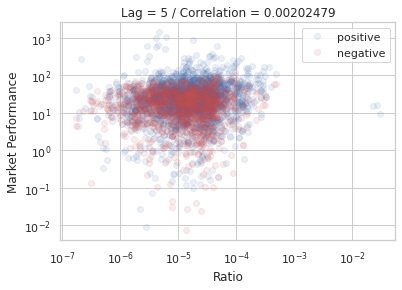

 75%|███████▌  | 6/8 [00:48<00:16,  8.21s/it]

[[1.         0.00465692]
 [0.00465692 1.        ]]


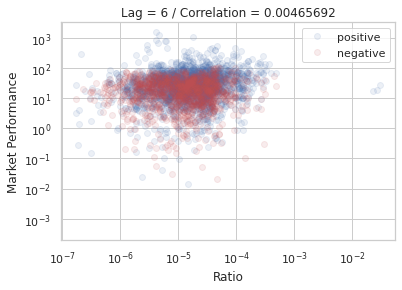

 88%|████████▊ | 7/8 [00:56<00:08,  8.12s/it]

[[1.         0.00459949]
 [0.00459949 1.        ]]


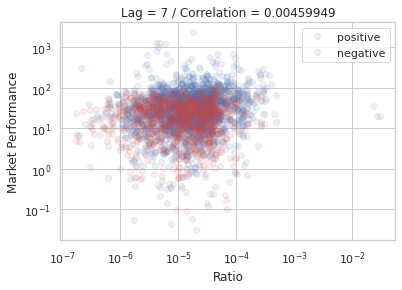

100%|██████████| 8/8 [01:04<00:00,  8.01s/it]


In [351]:
for d in tqdm(range(0, 8)):
    market_performance_list = []
    for i in range(len(df)):
        df1 = df.loc[i].merged_summary
        data = df.loc[i].stock_data
        df1['market_performance'] = df1.apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, d), axis=1)
        market_performance_list.append(df1['market_performance'].values)

    ratio_all = np.concatenate([df.loc[i].ratio for i in range(len(df))])
    market_performance_all = np.concatenate([market_performance_list[i][1:] for i in range(len(df))])

    # remove nans
    arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
    ratio_all = ratio_all[~arg_nan]
    market_performance_all = market_performance_all[~arg_nan]

    # remove outliers (ratio >= 1)
    arg_outliers = ratio_all >= 1
    ratio_all = ratio_all[~arg_outliers]
    market_performance_all = market_performance_all[~arg_outliers]

    print(np.corrcoef(ratio_all, market_performance_all))

    plt.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1, c= 'b', label = 'positive')
    plt.loglog(ratio_all, -market_performance_all, 'o', alpha = 0.1, c = 'r', label = 'negative')
    plt.xlabel('Ratio')
    plt.ylabel('Market Performance')
    plt.title('Lag = ' + str(d) + ' / ' + 'Correlation = ' + str(np.round(np.corrcoef(ratio_all, market_performance_all)[0,1], 8)))
    plt.legend()
    plt.show()


In [353]:
d_list = np.arange(0, 40)
corr_coef_list = []
for d in tqdm(d_list):
    market_performance_list = []
    for i in range(len(df)):
        df1 = df.loc[i].merged_summary
        data = df.loc[i].stock_data
        df1['market_performance'] = df1.apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, d), axis=1)
        market_performance_list.append(df1['market_performance'].values)

    ratio_all = np.concatenate([df.loc[i].ratio for i in range(len(df))])
    market_performance_all = np.concatenate([market_performance_list[i][1:] for i in range(len(df))])

    # remove nans
    arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
    ratio_all = ratio_all[~arg_nan]
    market_performance_all = market_performance_all[~arg_nan]

    # remove outliers (ratio >= 1)
    arg_outliers = ratio_all >= 1
    ratio_all = ratio_all[~arg_outliers]
    market_performance_all = market_performance_all[~arg_outliers]

    corr_coef = np.corrcoef(ratio_all, market_performance_all)
    corr_coef_list.append(corr_coef[0,1])

100%|██████████| 40/40 [04:48<00:00,  7.21s/it]


Text(0.5, 1.0, 'Max Correlation: 0.13168504')

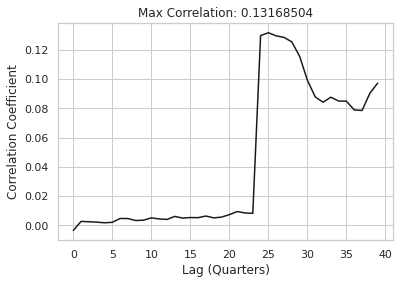

In [354]:
plt.plot(d_list, corr_coef_list, c = 'k')
plt.xlabel('Lag (Quarters)')
plt.ylabel('Correlation Coefficient')
plt.title('Max Correlation: {}'.format(np.round(np.max(corr_coef_list), 8)))

[[1.         0.13168504]
 [0.13168504 1.        ]]


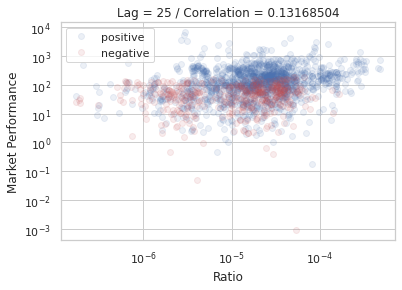

In [356]:
d = 25
market_performance_list = []
for i in range(len(df)):
    df1 = df.loc[i].merged_summary
    data = df.loc[i].stock_data
    df1['market_performance'] = df1.apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, d), axis=1)
    market_performance_list.append(df1['market_performance'].values)

ratio_all = np.concatenate([df.loc[i].ratio for i in range(len(df))])
market_performance_all = np.concatenate([market_performance_list[i][1:] for i in range(len(df))])

# remove nans
arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
ratio_all = ratio_all[~arg_nan]
market_performance_all = market_performance_all[~arg_nan]

# remove outliers (ratio >= 1)
arg_outliers = ratio_all >= 1
ratio_all = ratio_all[~arg_outliers]
market_performance_all = market_performance_all[~arg_outliers]

print(np.corrcoef(ratio_all, market_performance_all))

plt.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1, c= 'b', label = 'positive')
plt.loglog(ratio_all, -market_performance_all, 'o', alpha = 0.1, c = 'r', label = 'negative')
plt.xlabel('Ratio')
plt.ylabel('Market Performance')
plt.title('Lag = ' + str(d) + ' / ' + 'Correlation = ' + str(np.round(np.corrcoef(ratio_all, market_performance_all)[0,1], 8)))
plt.legend()
plt.show()

100%|██████████| 9/9 [00:57<00:00,  6.41s/it]


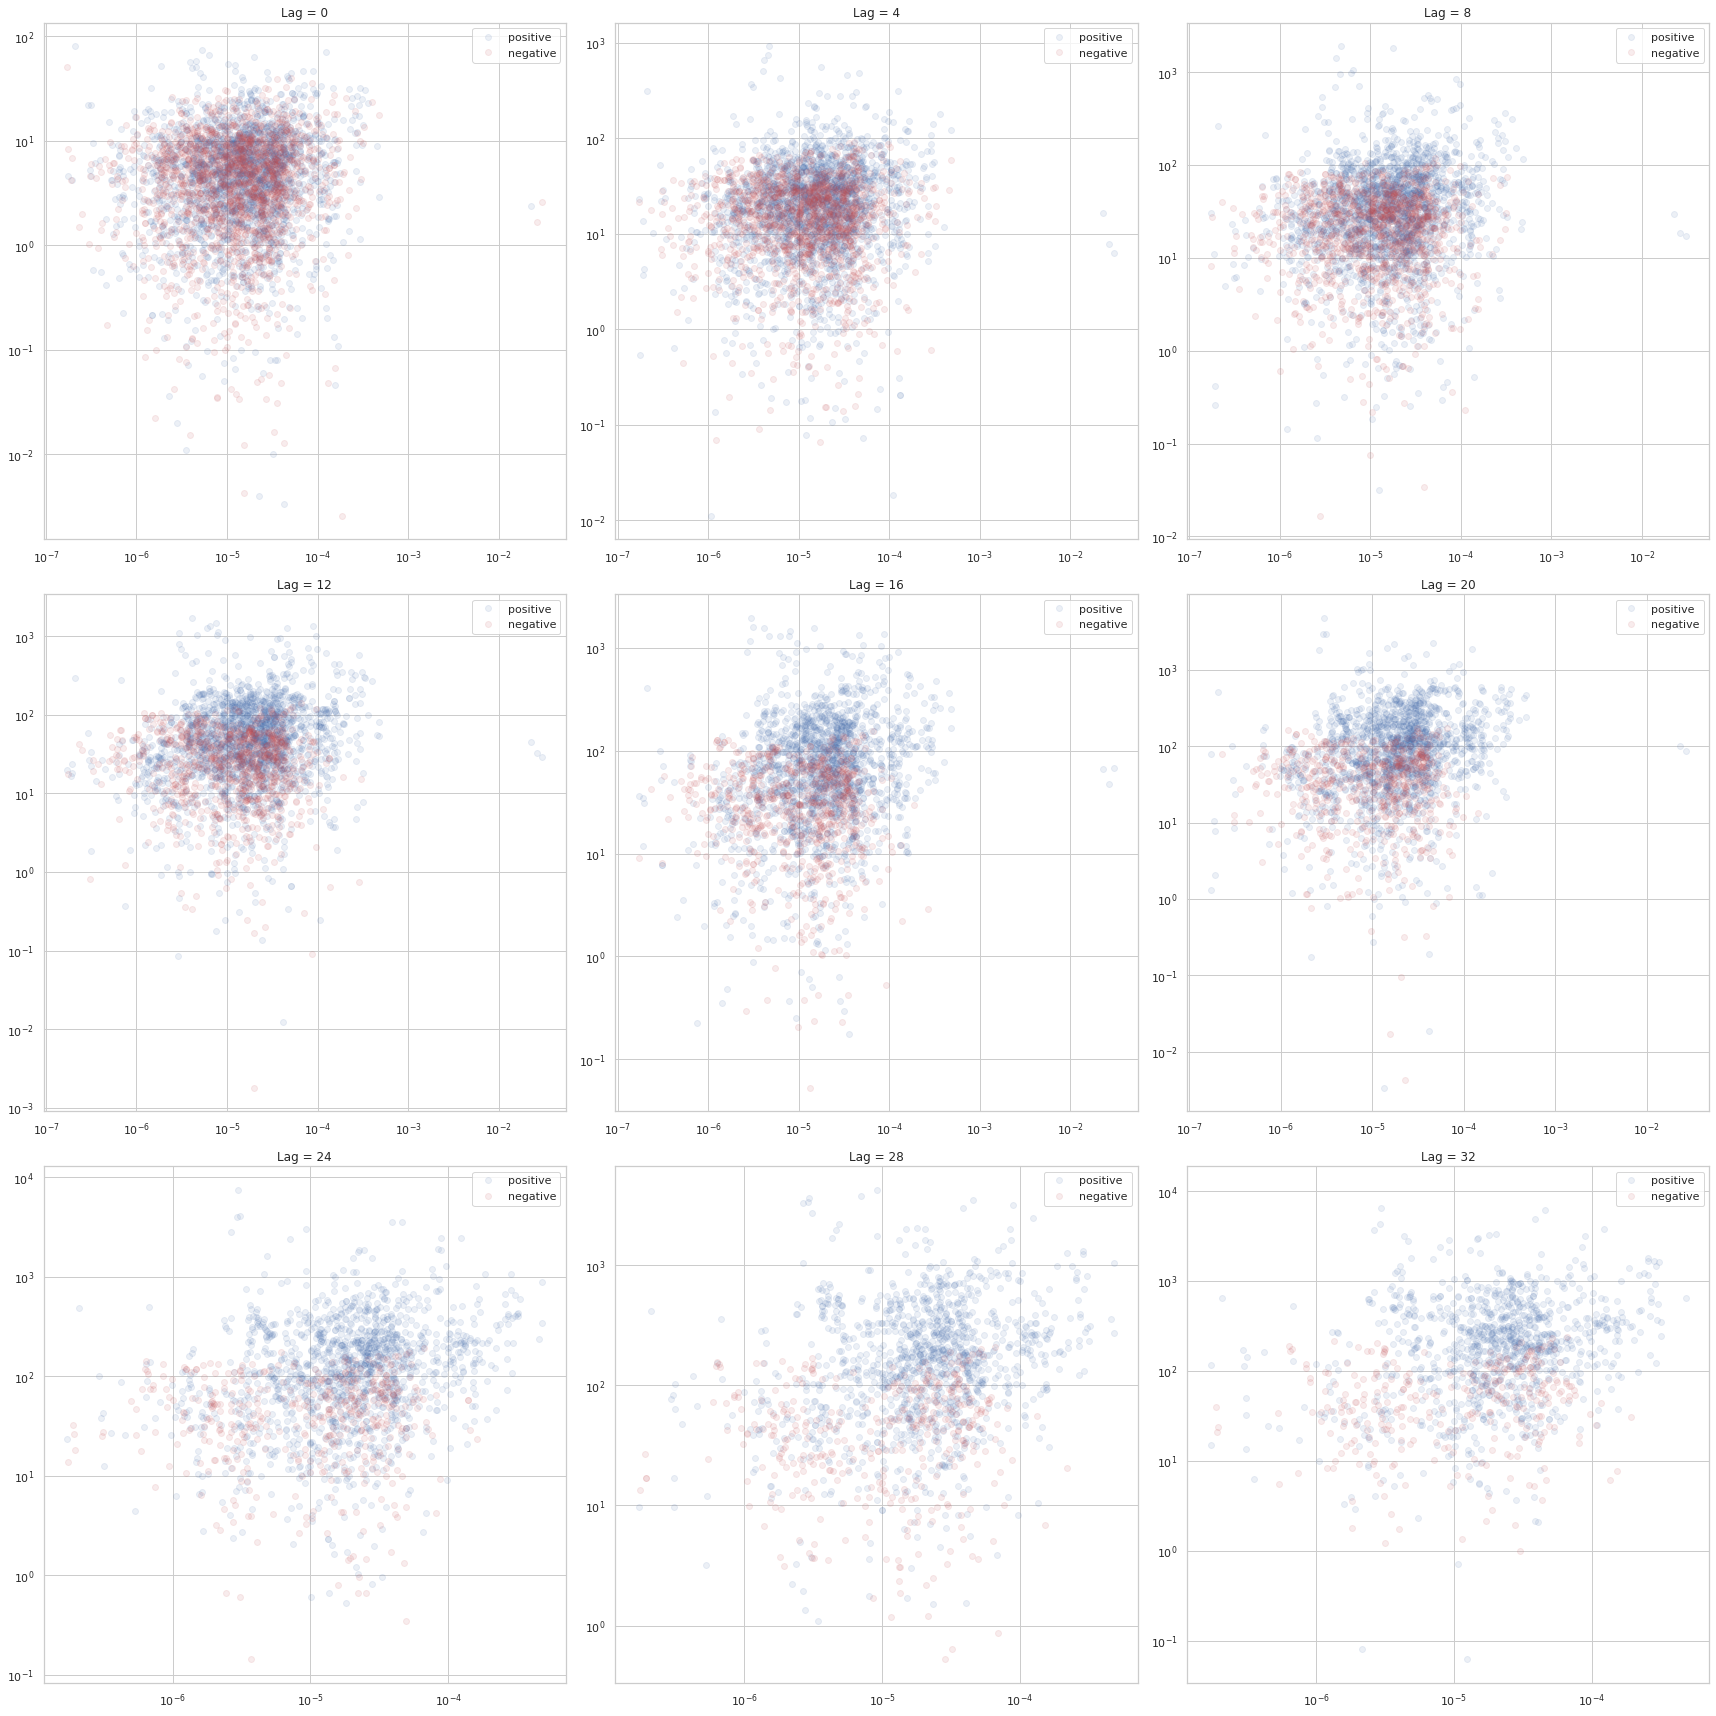

In [361]:
d_list = np.arange(0, 36, 4)
corr_coef_list = []
fig = plt.figure(figsize=(24, 24))
for d in tqdm(d_list):
    market_performance_list = []
    for i in range(len(df)):
        df1 = df.loc[i].merged_summary
        data = df.loc[i].stock_data
        df1['market_performance'] = df1.apply(lambda x: get_market_performance(data, sp500_data, x.year, x.quarter, d), axis=1)
        market_performance_list.append(df1['market_performance'].values)

    ratio_all = np.concatenate([df.loc[i].ratio for i in range(len(df))])
    market_performance_all = np.concatenate([market_performance_list[i][1:] for i in range(len(df))])

    # remove nans
    arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
    ratio_all = ratio_all[~arg_nan]
    market_performance_all = market_performance_all[~arg_nan]

    # remove outliers (ratio >= 1)
    arg_outliers = ratio_all >= 1
    ratio_all = ratio_all[~arg_outliers]
    market_performance_all = market_performance_all[~arg_outliers]

    corr_coef = np.corrcoef(ratio_all, market_performance_all)
    corr_coef_list.append(corr_coef[0,1])

    ax = fig.add_subplot(3, 3, d//4 + 1)
    ax.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1, c= 'b', label = 'positive')
    ax.loglog(ratio_all, -market_performance_all, 'o', alpha = 0.1, c = 'r', label = 'negative')
    ax.set_title('Lag = ' + str(d))
    ax.legend()

plt.tight_layout()